## General ZAF MODEL:

In [4]:
import math
import pandas as pd
import numpy as np
import sqlite3

# import MAC
mac_df = pd.read_csv("Henke 1993.txt")
# !inputs: concentrations, take off angle and accelerating voltage
elements = ['Fe','Ni']
C = {'Fe':0.1, 'Ni':0.9}
Ec = {'Fe': 7.11, 'Ni': 8.332} ### Check if you have to add all the lines and what to put for H
A = {'Fe':55.847, 'Ni': 58.71}
Z = {'Fe':26, 'Ni': 28}
# xray database
con = sqlite3.connect('xraydb.sqlite')
cur = con.cursor()
query = """
SELECT * FROM xray_transitions WHERE """

## Experimental conditions
take_off_angle = 40
E0 = 15 # keV

# for the emission of 
emission = {'element':'Fe', 'line':'Ka'}

# calculating X for each element
print("[+] The program is considering the emission of ", emission['element'], emission['line'])
# Extracting the needed MAC from the Henke database
sample_mac = pd.DataFrame()
for idx, value in enumerate(elements):
    new_row = pd.DataFrame({'abs': [value], 'mac': [mac_df[(mac_df['zAbs'] == value) & (mac_df['zMes'] == emission['element'])][emission['line']].values[0]] })
    print(new_row)
    sample_mac = sample_mac.append(new_row, ignore_index=True)
print(sample_mac)
print(mac_df)

[+] The program is considering the emission of  Fe Ka
  abs  mac
0  Fe   68
  abs  mac
0  Ni   94
  abs  mac
0  Fe   68
1  Ni   94
     zAbs zMes     Ka  Kb   La   Lb   Ll   Ma   Mb
0       H    H      0   0    0    0    0    0    0
1       H   He      0   0    0    0    0    0    0
2       H   Li  10734   0    0    0    0    0    0
3       H   Be    970   0    0    0    0    0    0
4       H    B    161   0    0    0    0    0    0
...   ...  ...    ...  ..  ...  ...  ...  ...  ...
8458    U   Ra      0   0  118   67  175  864  775
8459    U   Ac      0   0  110   61  164  802  719
8460    U   Th      0   0  100   55  151  734  657
8461    U   Pa      0   0   94   51  143  689  615
8462    U    U      0   0   86  109  131  629  550

[8463 rows x 9 columns]


In [5]:
############### Ai absorption general ############### 
# Calculating the X & sigma & h
# X
X = pd.DataFrame()
X_tot = 0
# sigma
sigma = pd.DataFrame()
sigma_tot = 0
# h
h = pd.DataFrame()
h_tot = 0
for idx, value in enumerate(elements):
    # calculating X
    new_row = pd.DataFrame({'element': [value], 'X': sample_mac[sample_mac['abs'] == value]['mac'].values[0] * (1/math.sin(math.radians(take_off_angle)))})
    X = X.append(new_row, ignore_index=True)
    # calculating X total
    X_tot = X_tot + C[value] * sample_mac[sample_mac['abs'] == value]['mac'].values[0] * (1/math.sin(math.radians(take_off_angle)))
    # Calculating sigma
    new_row = pd.DataFrame({'element': [value], 'sigma': (4.5*pow(10,5))/(pow(E0, 1.65)-pow(Ec[value], 1.65))})
    sigma = sigma.append(new_row, ignore_index=True)
    # calculating sigma total
    sigma_tot = sigma_tot + C[value] * (4.5*pow(10,5))/(pow(E0, 1.65)-pow(Ec[value], 1.65))
    # calculating h; h = 1.2 * A/Z^2
    new_row = pd.DataFrame({'element': [value], 'h': 1.2 * A[value]/pow(Z[value],2)}) 
    h = h.append(new_row, ignore_index=True)
    # calculating h total
    h_tot = h_tot + C[value] * 1.2 * A[value]/pow(Z[value],2)
# calculating the 1/f(X)
reverse_f_X = (1 + X_tot/sigma_tot)*(1 + (h_tot/(1+h_tot))*X_tot/sigma_tot)
print("Absorption correction factor for",emission['element'] , emission['line'], reverse_f_X)

Absorption correction factor for Fe Ka 1.018791636904012


In [6]:
#### Fluorescence F ####
# correction negligible if (E-Ec) > 5keV
# The mean depth of production of fluorescence radiation is greater than that of primary radiation (electrons)
# The correction factor Ifij/Ii relates the intensity of radiation of element i produced by fluorescence by element j, Ifij, 
# to the electron-generated intensity of radiation from element i, Ii;.
# REED (1965)
# absorption jump ratio
"""
    @input: list of elements causing the parasitic fluorescence "Fluorescer"
"""
# Test data
# to remove!!!!!
# C = {'Ni': 0.9, 'Fe': 0.1}
# emission = {'element':'Fe', 'line':'Ka'}
# End test data
# inputs 

fluorescers = ['Ni']
fluo_line = ['Ka']
fluo_yield = {'Ni': 0.37}
# Pij factor for the type of fluorescence occuring, if KK ( a K line fluoresces a K line) or LL fluorescence occurs Pij=1; KL or LK Pij = 4.76 for LK and 0.24 for KL
Pij = 1
# (r_i - 1)/r_i = 0.88 for K line and equal 0.75 for L line 
abs_jump_ratio = {'K':0.88, 'L': 0.75}
# Y_0 = 0.5 * ((r_i - 1)/r_i) * w_j * (A_i/A_j)
## Fe
"""
    abs_jump_ration @input
"""
# is the mass absorption coefficient of the specimen for radiation from element i,
# i emitter, j absorber
mac_sample_i = 0
for idx2,value2 in enumerate(elements):
    mac_sample_i = mac_sample_i + C[value2] * mac_df[(mac_df['zAbs'] == value2) & (mac_df['zMes'] == emission['element'])][emission['line']].values[0]

Ifij_by_Ii = 0
for idx, value in enumerate(fluorescers):
    # abs_jump_ratio used for K line since we are interested by the K line of the element
    Y_0 = 0.5 * (abs_jump_ratio['K'] * fluo_yield[value] * (A[emission['element']]/A[value]))
    Ui = E0/Ec[emission['element']]
    Uj = E0/Ec[value]
    Y_1 = pow(((Uj - 1)/(Ui - 1)), 1.67)
    
    # mac_ij is the mass absorption coefficient of element i for radiation from element j
    # mac_j_spec is the mass absorption coefficient of the specimen for radiation from element j
    # is the mass absorption coefficient of the specimen for radiation from element j.
    mac_sample_j = 0
    for idx2,value2 in enumerate(elements):
        mac_sample_j = mac_sample_j + C[value2] * mac_df[(mac_df['zAbs'] == value2) & (mac_df['zMes'] == value)][fluo_line[idx]].values[0]
    Y_2 = mac_df[(mac_df['zAbs'] == emission['element']) & (mac_df['zMes'] == value)][fluo_line[idx]].values[0]
    Y_2 = Y_2/mac_sample_j

    # Y3 account for absorption
    u = ((mac_sample_i)/(mac_sample_j)) * (1/math.sin(math.radians(take_off_angle)))
    
    # Ec is evaluated for element i
    v = (3.3 * pow(10,5))/((pow(E0,1.65) - pow(Ec[emission['element']],1.65))*(mac_sample_j))

    Y_3 = (math.log(1 + u)/u) + (math.log(1+v)/v)
    # in case the standard is a pure element
    Ifij_by_Ii = Ifij_by_Ii + C[value]*Y_0*Y_1*Y_2*Y_3*Pij
Fi = 1/(1 + Ifij_by_Ii)
print("E0, take off angle,", E0,",",take_off_angle)
print("If_Fe_Ni/I_Fe, ", Ifij_by_Ii)
print("Emitting element", emission['element'], emission['line'], 'studied,', 'Fluorescers: ', fluo_line,', Fi Correction:', Fi)

E0, take off angle, 15 , 40
If_Fe_Ni/I_Fe,  0.21128892283645745
Emitting element Fe Ka studied, Fluorescers:  ['Ka'] , Fi Correction: 0.8255668661266338


## Z correction:

In [8]:
#### Atomic Number Factor Z ####
# The so-called atomic number effect in electron microprobe analysis arises from two phenomena, namely, electron backscattering and electron retardation.
# both of which depend upon the average atomic number of the target.
# ! this correction is needed if there is a difference between the average atomic number of the specimen and that of the standard
# “light elements in a heavy matrix usually yield values which are too high.” ([Goldstein et al., 1981, p. 317])

# calculating the average Z of the sample
avg_z_spec = 0
for idx, value in enumerate(elements):
    avg_z_spec = avg_z_spec + C[value] * Z[value]
print('Average atomic number of the specimen: ',avg_z_spec)
############################## for Cu Ka ############################## 
## R backscattering correction factors range from 0.5-1 (close to 1 at low atomic numbers) 
# varies with Z and overvoltage U = Eo/Ec (as decreases towards 1 few electrons are backscattered
R = np.zeros((len(elements),len(elements)))
Ri = np.zeros((len(elements),))
for idx1, value1 in enumerate(elements):
    for idx2, value2 in enumerate(elements):
        print(value1, value2)
        U = E0/Ec[value1]
        R1 = 8.73 * 0.001 * pow(U,3) - 0.1669 * pow(U,2) + 0.9662 * U + 0.4523
        R2 = 2.703 * 0.001 * pow(U,3) - 5.182 * 0.01 * pow(U,2) + 0.302*U -0.1836
        R3 = (0.887 * pow(U,3) - 3.44 * U * U + 9.33 * U - 6.43)/pow(U,3)
        R[idx1][idx2]= R1 - R2 * math.log(R3*Z[value2] + 25)
        Ri[idx1] = Ri[idx1] + C[value2] * R[idx1][idx2]
# index is the emitting element
Rij_df = pd.DataFrame(R, columns=elements, index=elements)
Ri = pd.DataFrame(Ri, columns=['R'], index=elements)
print("\n## Rij for the specimen:")
print(Rij_df)
print("\n## Ri for the specimen:")
print(Ri)

# Ri = sum(j) CjRij
# Ri = C[0] * Rij
# # mean ionization potential J = 9.76 * Z + 58.8 * pow(Z, -0.19) [eV] # Berger and Seltzer (1964) !!!! problems with Z < 11, by lot of authors
J = pd.DataFrame()
for idx,value in enumerate(elements):
    new_row = pd.DataFrame({'element': [value], 'J': 9.76 * Z[value] + 58.8 * pow(Z[value], -0.19)})
    J = J.append(new_row, ignore_index=True)
print("\n## J for the specimen:")
print("J, ", J)
# # S is the electron stopping power 
# # “i represents the element i which is measured and j represents each of the elements present in the standard or specimen including element i.” ([Goldstein et al., 1981, p. 319]
S = np.zeros((len(elements),len(elements)))
Si = np.zeros((len(elements),))
for idx1, value1 in enumerate(elements):
    for idx2, value2 in enumerate(elements):
        S[idx1][idx2]= (Z[value1] / (A[value1]*(E0 + Ec[value2]))) * math.log(583*(E0+Ec[value2])/J[J['element'] == value2]['J'].values[0])
        Si[idx1] = Si[idx1] + C[value2] * S[idx1][idx2]
# index is the emitting element
S = pd.DataFrame(S, columns=elements, index=elements)
Si = pd.DataFrame(Si, columns=['S'], index=elements)
print("\n## S for the specimen:")
print("S", S)
print("\n## Si for the specimen:")
print("Si", Si)

## For the standard
# Using of element Cu
print("\n## For the standard Fe:")
Si_std = (Z["Fe"] / (A["Fe"]*(E0 + Ec["Fe"]))) * math.log(583*(E0+Ec["Fe"])/J[J["element"] =="Fe"]["J"].values[0])
print("Si standard, ", Si_std)

# R Standard
U = E0/Ec["Fe"]
R1 = 8.73 * 0.001 * pow(U,3) - 0.1669 * pow(U,2) + 0.9662 * U + 0.4523
R2 = 2.703 * 0.001 * pow(U,3) - 5.182 * 0.01 * pow(U,2) + 0.302*U -0.1836
R3 = (0.887 * pow(U,3) - 3.44 * U * U + 9.33 * U - 6.43)/pow(U,3)
Ri_std = R1 - R2 * math.log(R3*Z["Fe"] + 25)
print("Ri standard, ", Ri_std)
Z_Li = (Ri.iloc[0].values/Ri_std)*(Si_std/Si.iloc[0].values)
# print("Ri Li", Ri.iloc[0])
# print("Si Li", Si.iloc[0])
print('\n')
print("Z correction:", Z_Li[0])
print("A correction:", reverse_f_X)
print("F correction:", Fi)
ki = C['Fe'] / Z_Li[0] * reverse_f_X * Fi
I_std = 160000
Ii = ki * I_std
print("Amblygonite Intensity: ", Ii)
###"""
# As discussed earlier unless the atomic number effect is corrected for, 
# analyses of heavy elements in a light element matrix (Cu in AI) generally 
# yield values which are too low (Zj > I) while analyses of light elements 
# in a heavy matrix (AI in Cu) usually yield values which are too high (Zj < I).
#"""

Average atomic number of the specimen:  27.8
Fe Fe
Fe Ni
Ni Fe
Ni Ni

## Rij for the specimen:
          Fe        Ni
Fe  0.899728  0.892020
Ni  0.912284  0.905376

## Ri for the specimen:
           R
Fe  0.892791
Ni  0.906067

## J for the specimen:
J,    element           J
0      Fe  285.421566
1      Ni  304.498879

## S for the specimen:
S           Fe        Ni
Fe  0.080230  0.075811
Ni  0.082188  0.077661

## Si for the specimen:
Si            S
Fe  0.076253
Ni  0.078114

## For the standard Fe:
Si standard,  0.08023026356898227
Ri standard,  0.8997275137416874


Z correction: 1.0440523021030457
A correction: 1.018791636904012
F correction: 0.8255668661266338
Amblygonite Intensity:  12889.4786932903


## Example of Al in pure aluminum and in alumina quantification

In [5]:
## calculate the intensity by integrating the area under the peaks


# Figure for the EPMA paper

3.8.1


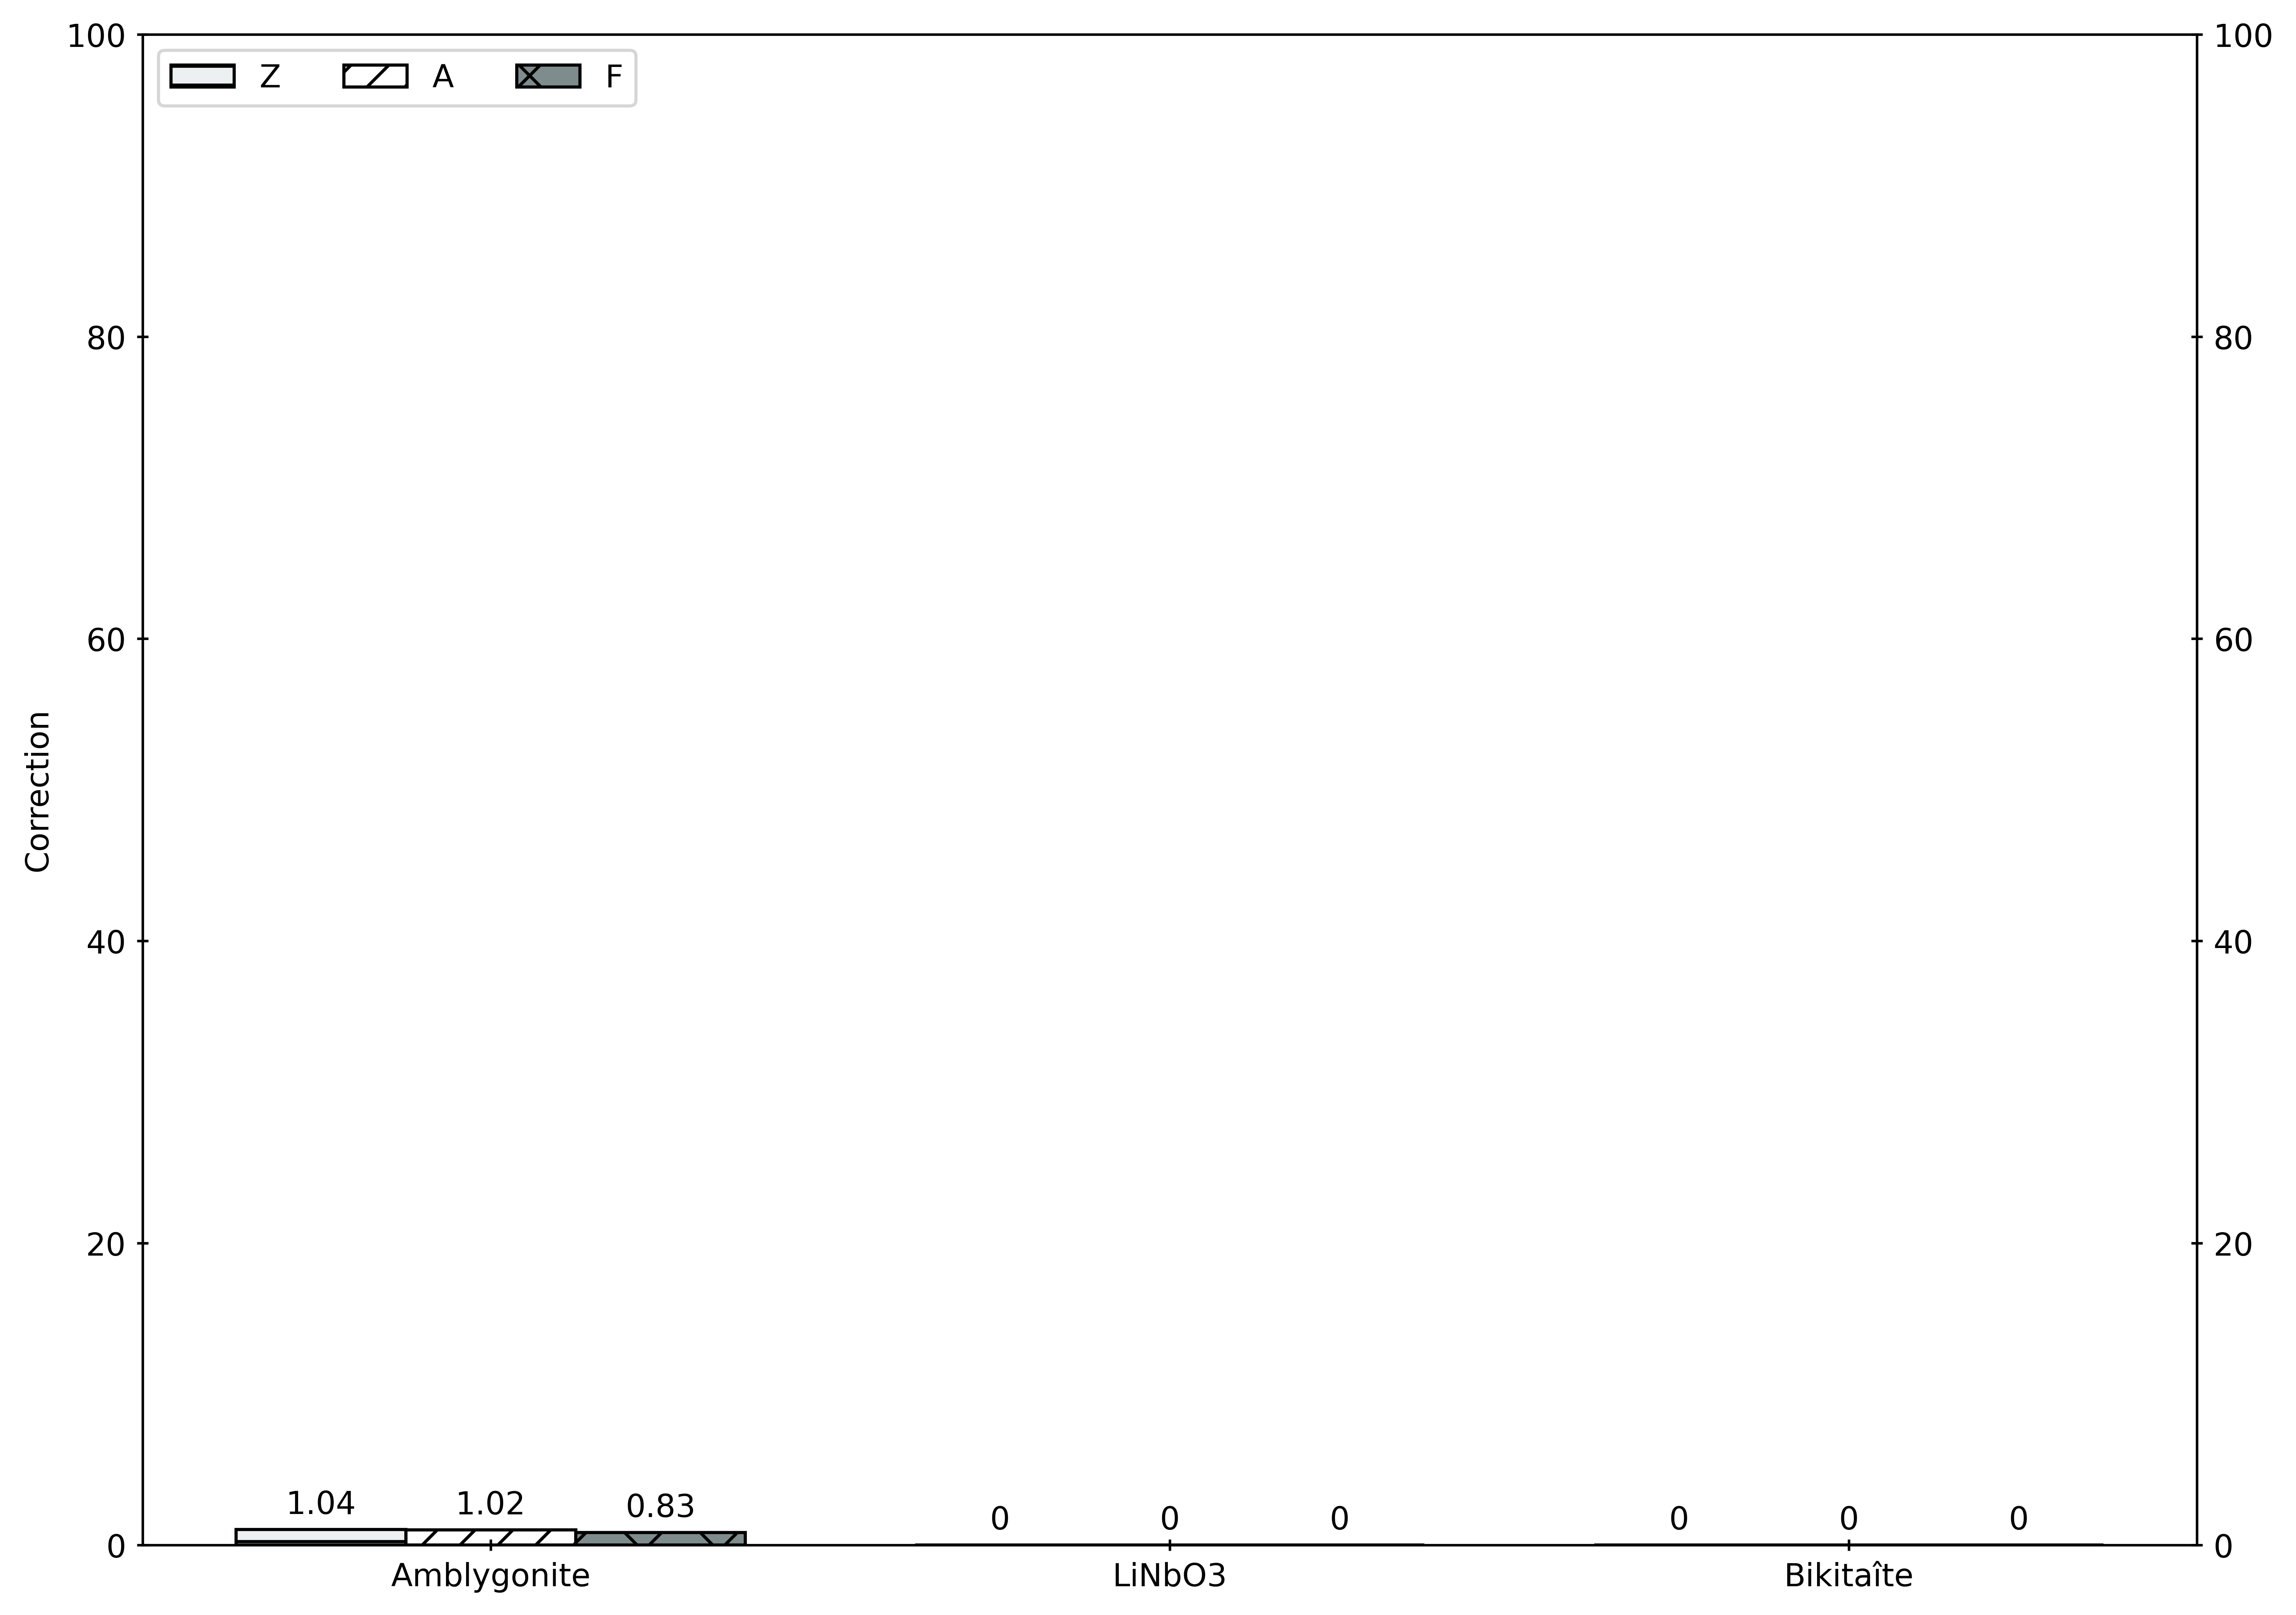

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
print(matplotlib.__version__)
font = {'size'   : 20, 'weight':'light'}
matplotlib.rc('font', **font)
species = ("Ni-Fe", "LiNbO3", "Bikitaîte")
penguin_means = {
    'Z': (float('{:.2f}'.format(Z_Li[0])), 0,0),
    'A': (float('{:.2f}'.format(reverse_f_X)), 0,0),
    'F': (float('{:.2f}'.format(Fi)), 0, 0),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10,7), dpi=600)
plt.tick_params(labelright=True)
ax.tick_params(which='both', direction='inout', right=True, top=False)
colors_list = ['#ecf0f1','#fff','#7f8c8d']
hatches = ['--','//','x']
i = 0
for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width,edgecolor='black',label=attribute, color=colors_list[i], hatch=hatches[i])
    ax.bar_label(rects, padding=3)
    multiplier += 1
    i += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correction')
ax.set_title('')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 100)

plt.show()